# 80_ra271.352_dec-29.642_MAXIJ1803

In [16]:
from pathlib import Path
import numpy as np
import arviz as az
import graphviz as gv
import utility_functions as ufn
import importlib

importlib.reload(ufn)
az.style.use("arviz-white")

RANDOM_SEED = 2023-11-21
rng = np.random.default_rng(RANDOM_SEED)

OVERWRITE_TRACES = True

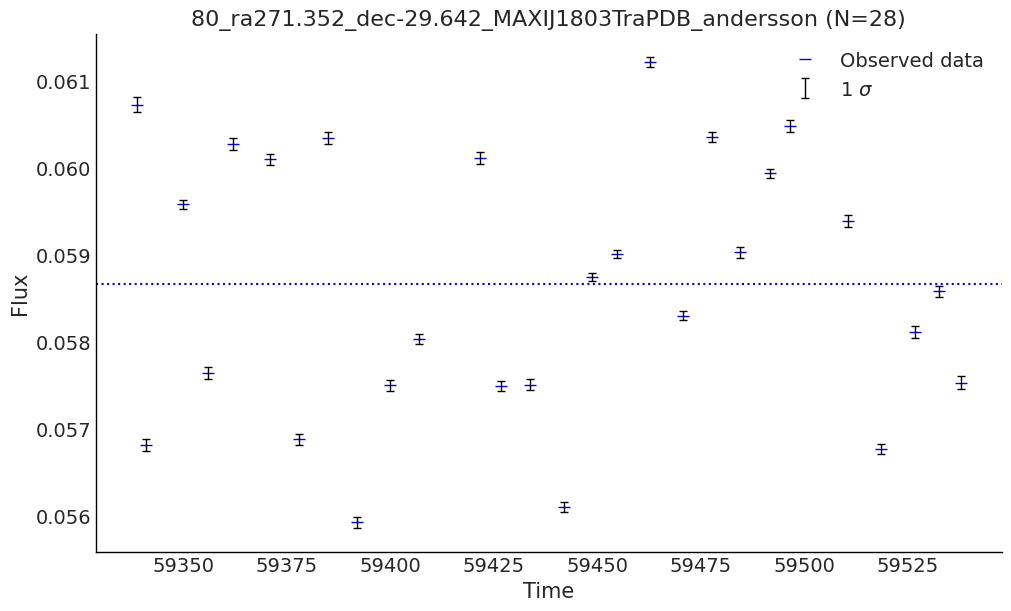

In [17]:
# File paths to CSVs of flux density observations.
csv_paths_list = sorted(list(Path('data_raw').iterdir()))
csv_path = csv_paths_list[3]
ufn.plot_lc(csv_path)

## SE GP + Periodic GP

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{GP}(\boldsymbol{0}, k_\textrm{SE}(\tau)) + \mathcal{GP}(\boldsymbol{0}, k_\textrm{P}(\tau))$$

$$k_\textrm{SE}(\tau) = \eta_\textrm{SE}\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\}, \quad k_\textrm{P}(\tau) = \eta_\textrm{P} \exp \left\{ -\frac{1}{2\ell^2_\textrm{P}}\sin^2 \left(\pi\frac{\tau}{T}\right)\right\}$$

$$\ell_\textrm{SE} \sim \textrm{InvGamma}(\alpha = 3, \beta = 8 \times \textrm{min. t gap})$$

$$\ell_\textrm{P} \sim \textrm{InvGamma}(\alpha = 3, \beta = 8 \times \textrm{min. t gap})$$

$$\eta_\textrm{SE} \sim \mathcal{N}^+(0, 1)$$

$$\eta_\textrm{P} \sim \mathcal{N}^+(0, 1)$$

$$T \sim \mathcal{U}[\textrm{t max gap}, \textrm{t range}]$$

$$\sigma_{\textrm{WN},i} \sim \mathcal{N}^+(\textrm{std err}(y_i), \textrm{SD}(\textrm{std err}(\boldsymbol{y})))$$

Sampling: [T, ell_Per, ell_SE, eta_Per, eta_SE, sig, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta_SE, eta_Per, ell_SE, ell_Per, T, sig]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 360 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [f_star, f_star_Per, f_star_SE]


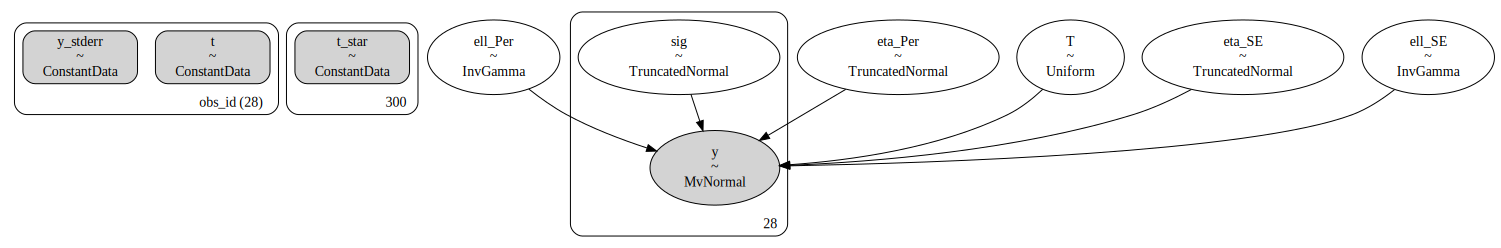

In [18]:
gpSE_gpPer_trace_path = Path(f"traces/{csv_path.stem}_gpSE_gpPer_idata.nc")
gpSE_gpPer_dag_path = Path(f'dags/{csv_path.stem}_gpSE_gpPer_dag.dot')

if gpSE_gpPer_trace_path.is_file() and not OVERWRITE_TRACES:
    gpSE_gpPer_trace = az.from_netcdf(gpSE_gpPer_trace_path)
    gpSE_gpPer_dag = gv.Source.from_file(gpSE_gpPer_dag_path)
else:
    gpSE_gpPer_trace, gpSE_gpPer_dag = ufn.fit_gpSE_gpPer(csv_path, rng_seed=rng);
    az.to_netcdf(gpSE_gpPer_trace, gpSE_gpPer_trace_path)
    with open(gpSE_gpPer_dag_path, 'w') as writehandle:
        writehandle.write(gpSE_gpPer_dag.source)

gv.Source(gpSE_gpPer_dag.source)

In [20]:
variable_names = ["ell_SE", "ell_Per", "eta_SE", "eta_Per", "T"]
ufn.print_post_summary(gpSE_gpPer_trace, variable_names)

,median,mad,eti_16%,eti_84%,mcse_median,ess_median,ess_tail,r_hat,mean,sd
ell_SE,9.990819,4.780343e+00,4.871033e+00,32.395122,7.842926e-01,136.808152,393.476137,1.023806,21.496560,50.729092
ell_Per,21.835123,1.090089e+01,1.017668e+01,53.129948,1.176241e+00,359.968679,284.014937,1.004578,34.549847,43.987907
eta_SE,0.000001,6.545147e-07,4.993720e-07,0.000004,7.649972e-08,346.283141,229.230103,1.013084,0.000832,0.017556
eta_Per,0.013611,1.144687e-02,2.521288e-03,0.093657,1.588556e-03,377.239152,411.023983,1.023987,0.070472,0.174481
T,12.767819,3.840110e-01,1.246651e+01,18.107725,4.391398e-01,19.676033,46.039800,1.164257,16.796658,8.874670


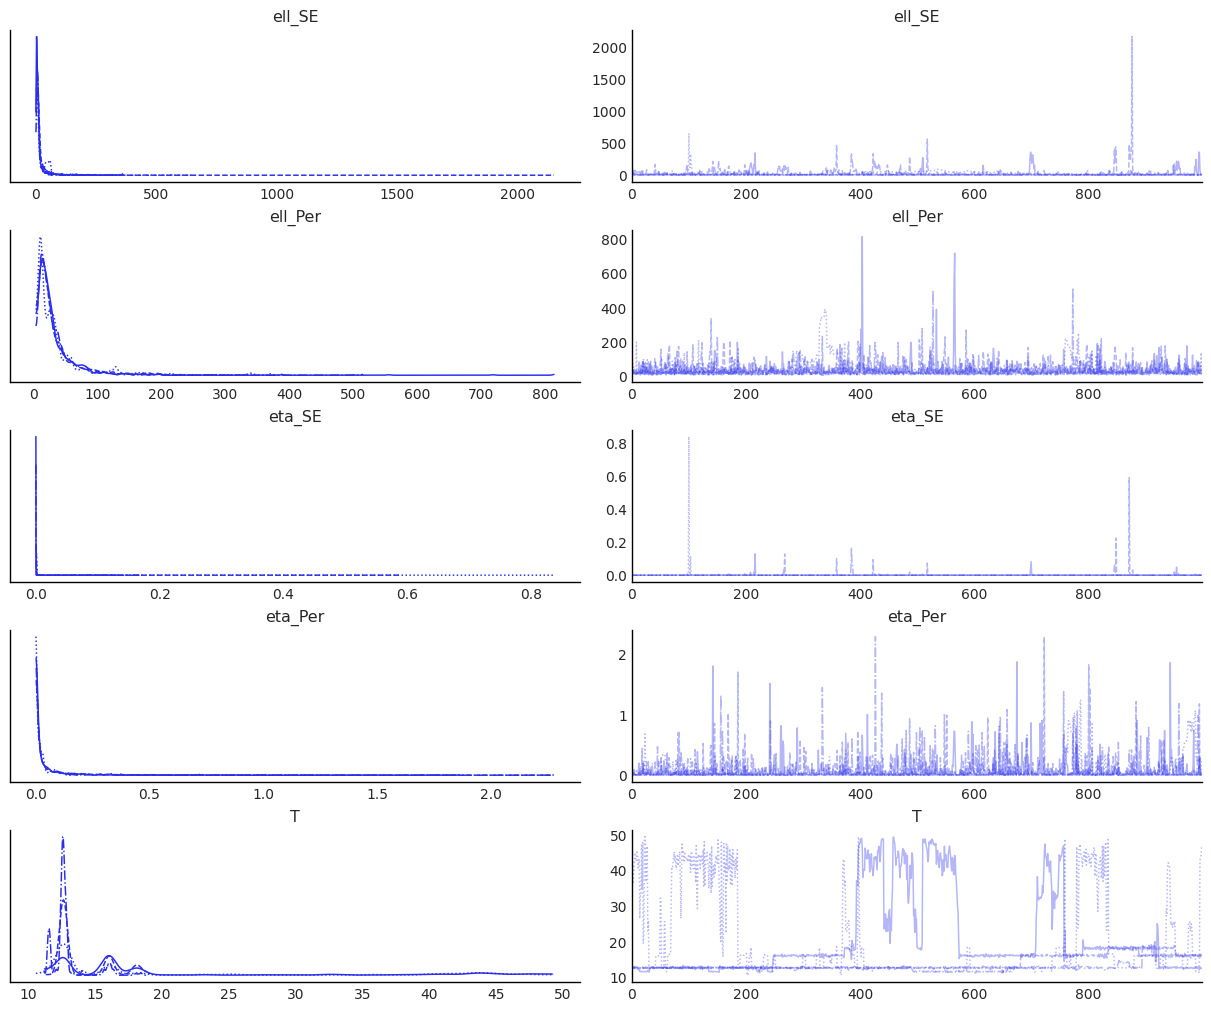

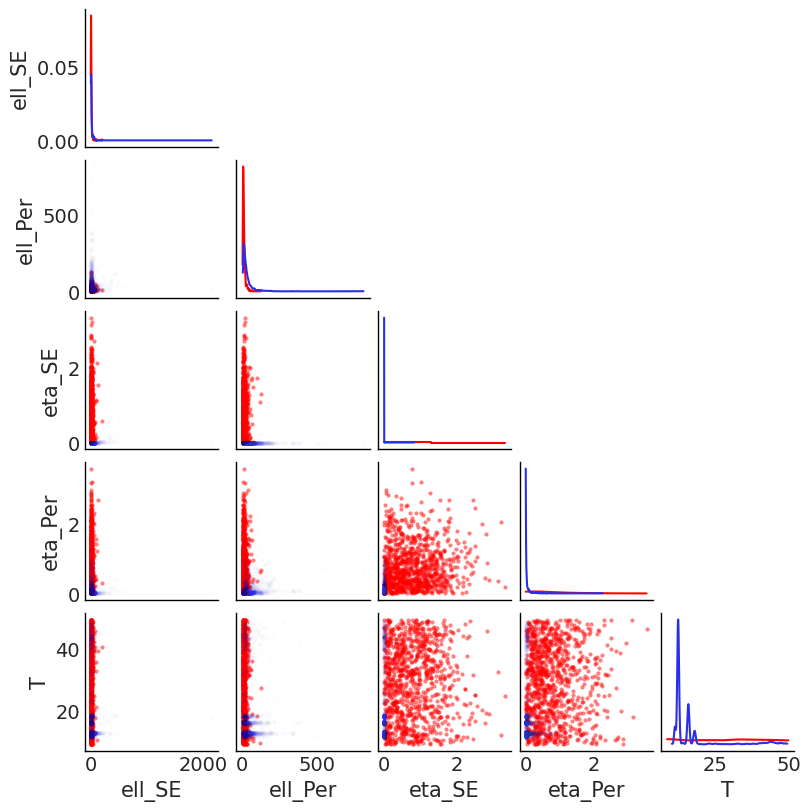

In [22]:
ufn.plot_traces(gpSE_gpPer_trace, variable_names)
ufn.plot_priorpost_cnr(gpSE_gpPer_trace, variable_names)

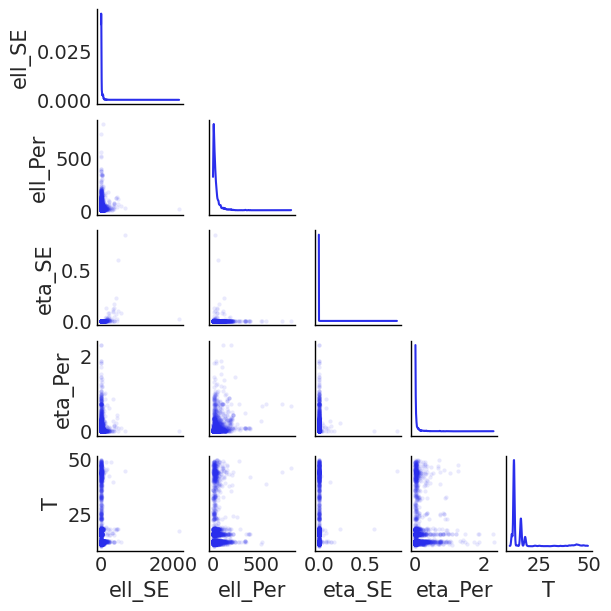

In [40]:
ufn.plot_post_cnr(gpSE_gpPer_trace, variable_names=variable_names)

In [44]:
az.extract(gpSE_gpPer_trace, group="posterior", var_names="T")

<xarray.DataArray 'T' (sample: 4000)>
array([12.65230131, 12.53164509, 12.67254666, ..., 15.66339551,
       16.40851518, 16.01158522])
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

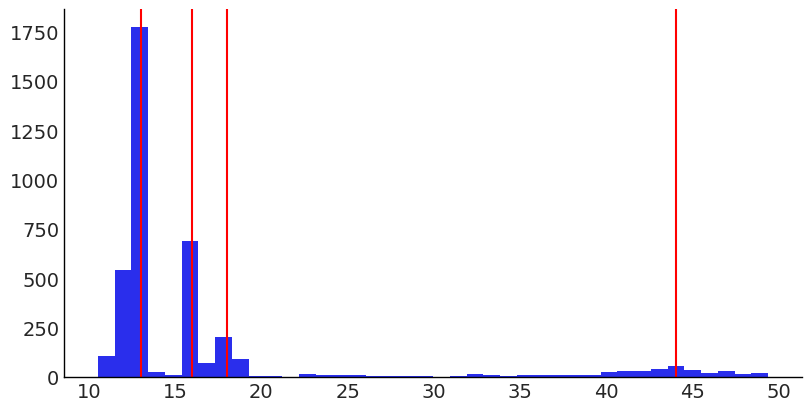

In [69]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
dens = ax.hist(az.extract(gpSE_gpPer_trace, group="posterior", var_names="T"), bins=40);
ax.axvline(x=13, c="r")
ax.axvline(x=16, c="r")
ax.axvline(x=18, c="r")
ax.axvline(x=44, c="r")

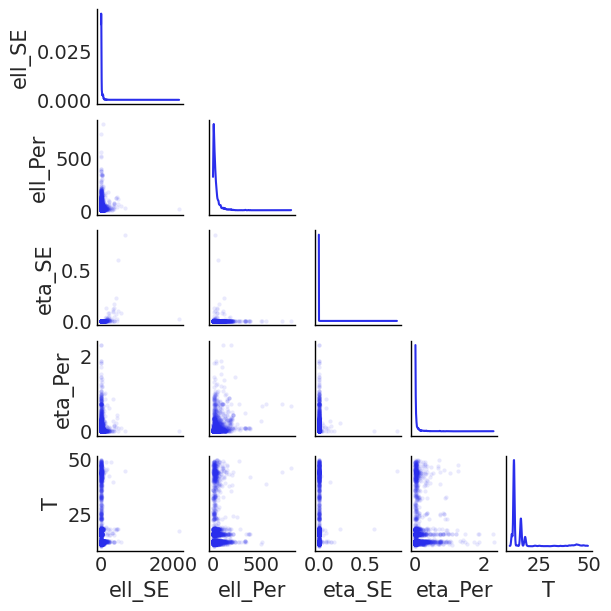

In [23]:
ufn.plot_post_cnr(gpSE_gpPer_trace,  variable_names=["ell_SE", "ell_Per", "eta_SE", "eta_Per", "T"])

/home/scf/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 28, using nperseg = 28
  warnings.warn('nperseg = {0:d} is greater than input length '


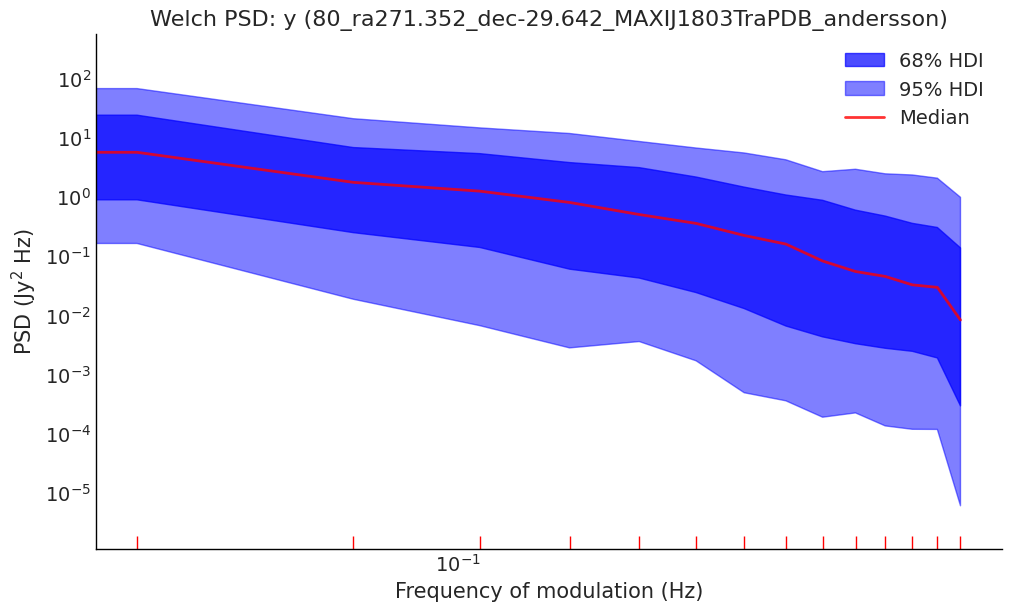

In [24]:
ufn.plot_welch_psd(gpSE_gpPer_trace, group="prior_predictive", variable_name="y")

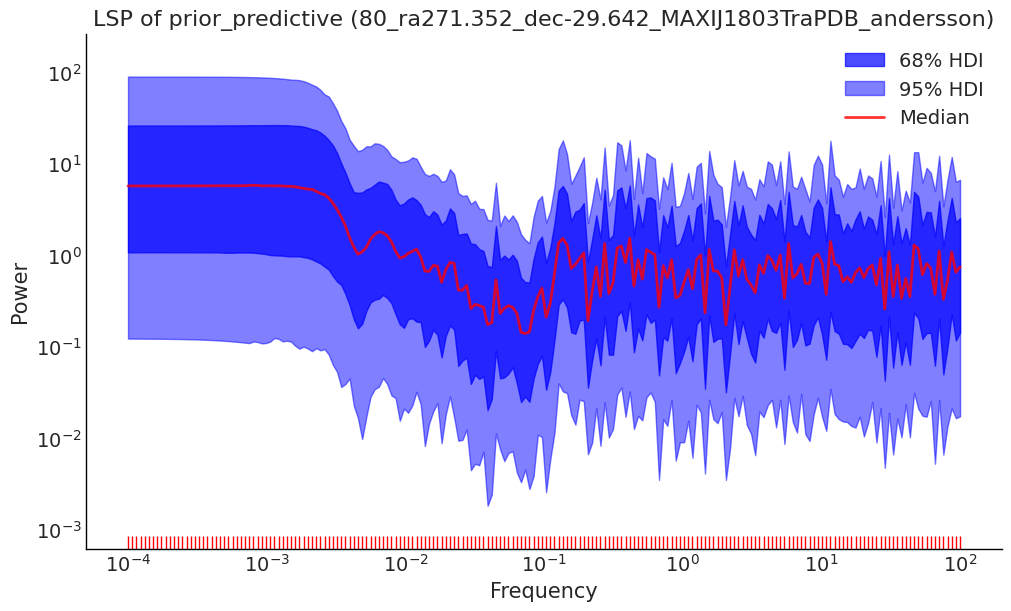

In [26]:
ufn.plot_lsp(gpSE_gpPer_trace, "prior_predictive", "y")

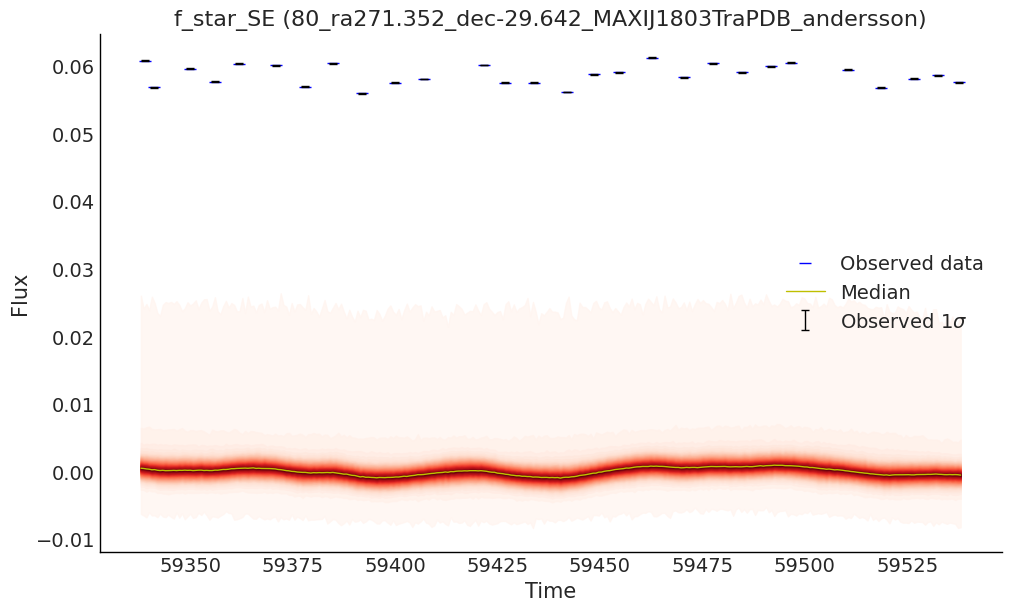

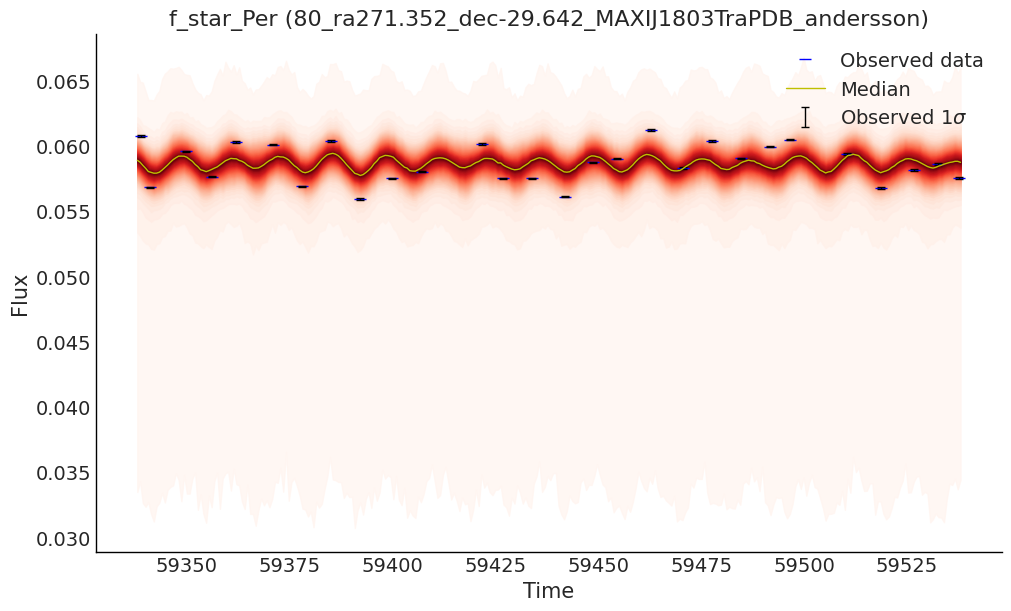

In [27]:
ufn.plot_postpred_samples(gpSE_gpPer_trace, "f_star_SE")
ufn.plot_postpred_samples(gpSE_gpPer_trace, "f_star_Per")

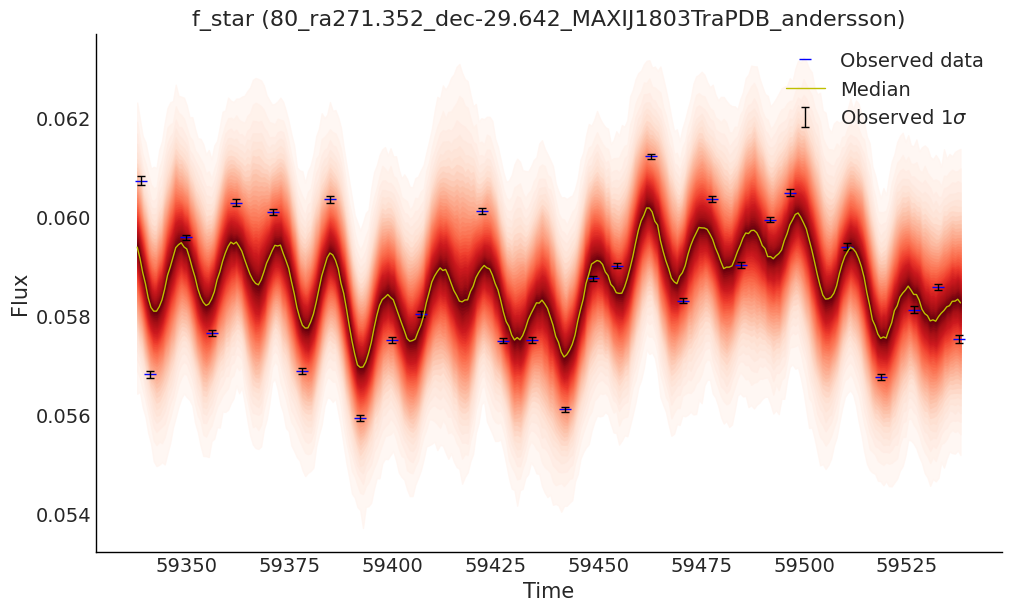

In [28]:
ufn.plot_postpred_samples(gpSE_gpPer_trace, "f_star")

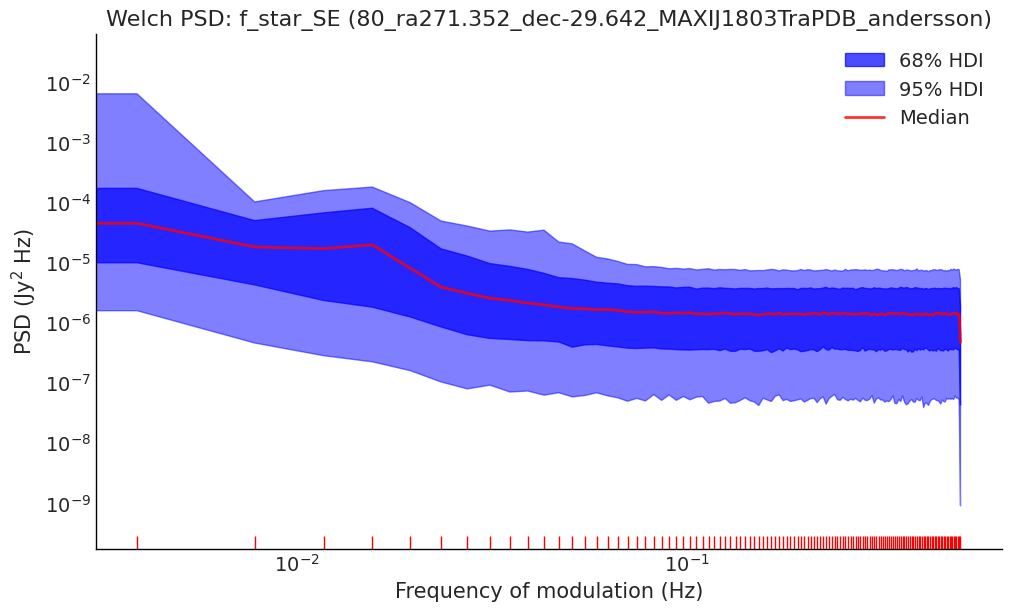

In [29]:
ufn.plot_welch_psd(gpSE_gpPer_trace, group="posterior_predictive", variable_name="f_star_SE");

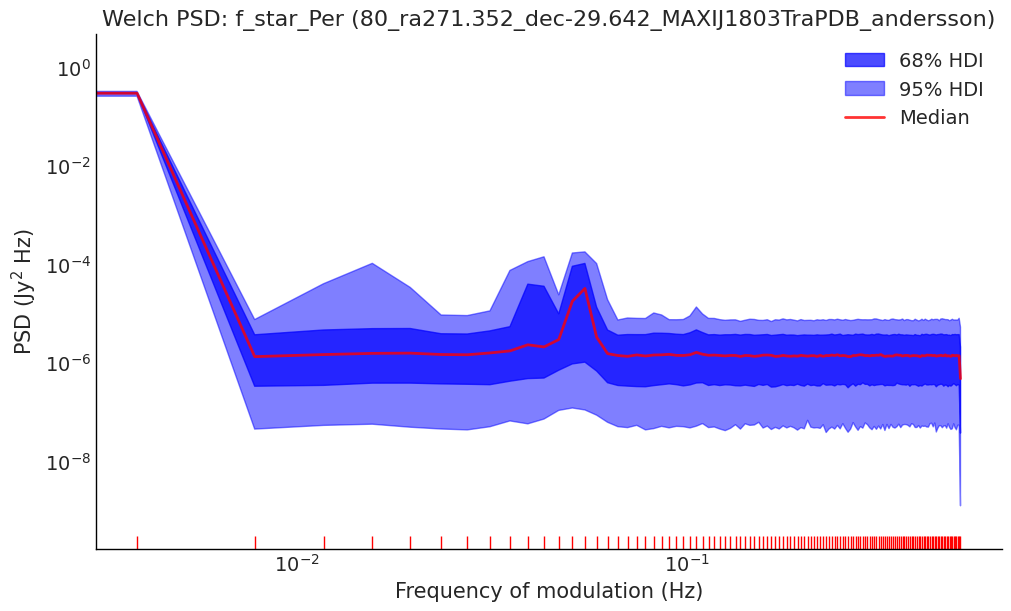

In [72]:
ufn.plot_welch_psd(gpSE_gpPer_trace, variable_name="f_star_Per");


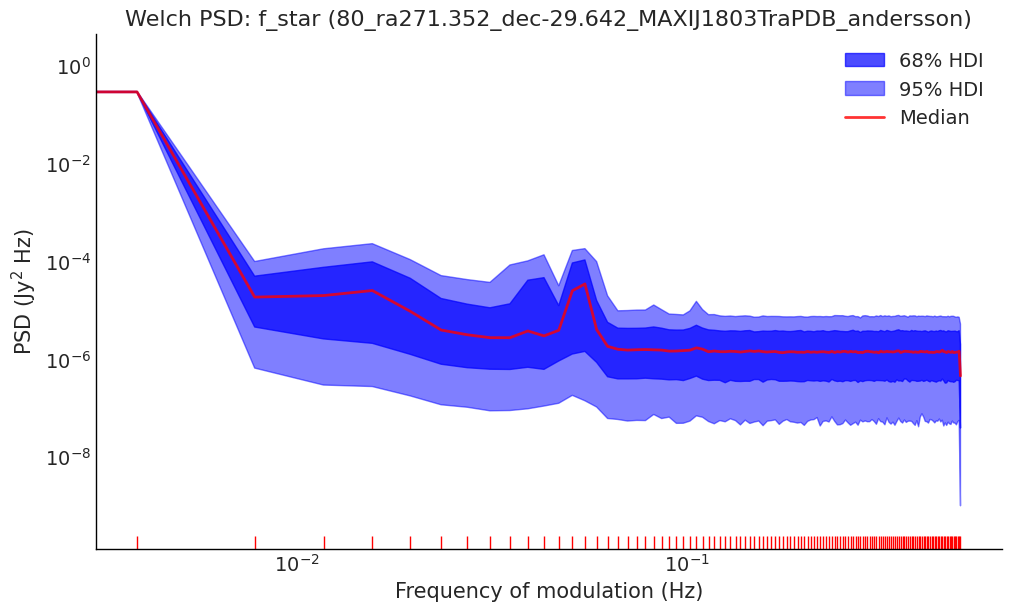

In [32]:
ufn.plot_welch_psd(gpSE_gpPer_trace, variable_name="f_star");

/home/scf/git-repos/gp-sandbox-thunderkat/utility_functions.py:230: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.loglog(freqs_nd, psd_median, lw=2, alpha=0.8, label=f"{var}")


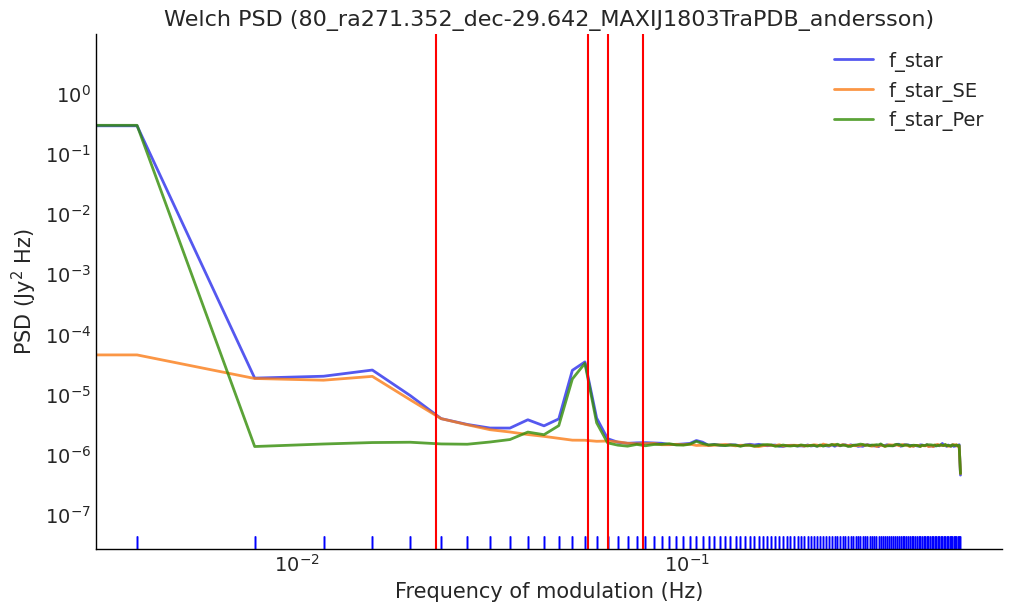

In [71]:
ufn.plot_welch_psds(gpSE_gpPer_trace, variable_names=["f_star", "f_star_SE", "f_star_Per"])
plt.axvline(x=1/13, c="r")
plt.axvline(x=1/16, c="r")
plt.axvline(x=1/18, c="r")
plt.axvline(x=1/44, c="r")

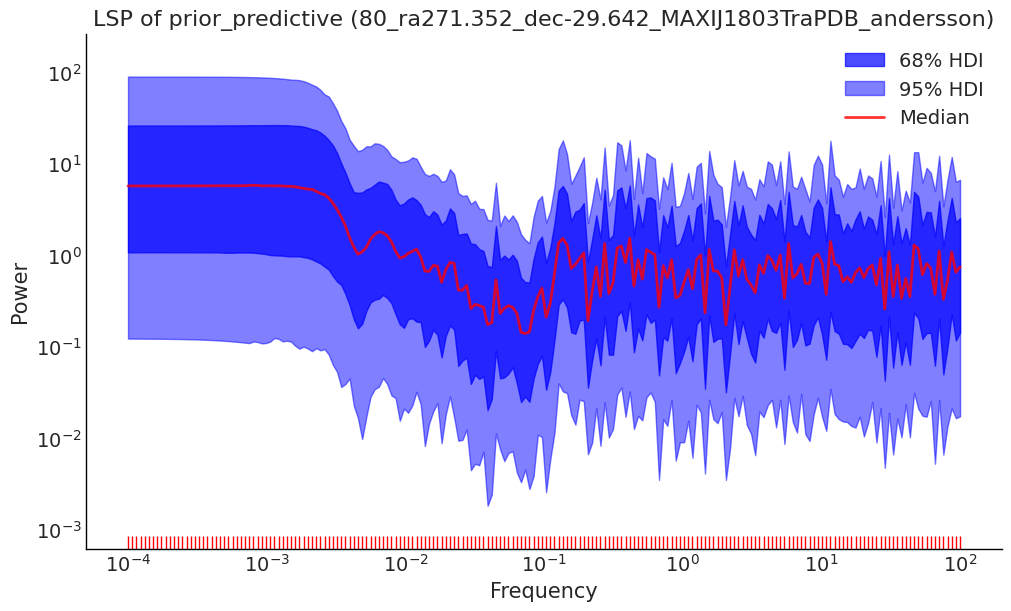

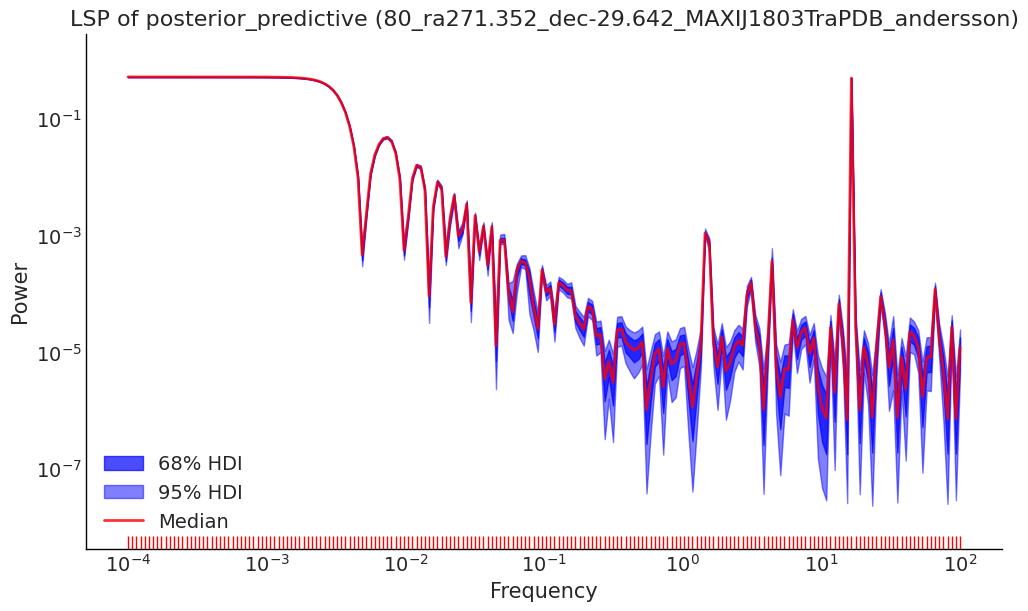

In [34]:
ufn.plot_lsp(gpSE_gpPer_trace, group="prior_predictive", variable_name="y")
ufn.plot_lsp(gpSE_gpPer_trace, group="posterior_predictive", variable_name="f_star")